# Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, accuracy_score
)
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [25]:
# Load the training and testing datasets
train_df = pd.read_csv('/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/train70_clf.csv')
test_df = pd.read_csv('/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/test30_clf.csv')

# Display the shape of the datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (104671, 37)
Testing set shape: (44860, 37)


In [26]:
train_df['titleType'].value_counts()

titleType
tvEpisode       49581
movie           25968
short           11465
tvSeries         6444
tvMovie          4240
video            3604
videoGame        1244
tvMiniSeries     1133
tvSpecial         804
tvShort           188
Name: count, dtype: int64

In [27]:
# Drop observations where titleType is 'videoGame'
train_df = train_df[train_df['titleType'] != 'videoGame']
test_df = test_df[test_df['titleType'] != 'videoGame']

# Define a mapping dictionary for titleType
titletype_mapping = {
    'movie': 'movie',
    'tvMovie': 'movie',
    'short': 'short',
    'tvShort': 'short',
    'tvSeries': 'tvSeries',
    'tvMiniSeries': 'tvSeries',
    'tvEpisode': 'tvEpisode',
    'tvSpecial': 'tvSpecial',
    'video': 'video'
}

# Apply the mapping to the titleType column
train_df['titleType'] = train_df['titleType'].map(titletype_mapping)
test_df['titleType'] = test_df['titleType'].map(titletype_mapping)

# Check the new unique values
print("New unique values in titleType:", train_df['titleType'].unique())


New unique values in titleType: ['movie' 'short' 'tvEpisode' 'tvSeries' 'video' 'tvSpecial']


In [28]:
train_df.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'numVotes', 'titleType', 'canHaveEpisodes', 'isAdult', 'numRegions',
       'ratingCount', 'countryOfOrigin', 'genres', 'companiesNumber',
       'averageRating', 'regions', 'soundMixes', 'totalMedia',
       'totalNominations', 'deltaCredits', 'regions_freq_enc', 'regions_EU',
       'regions_NA', 'regions_AS', 'regions_AF', 'regions_OC', 'regions_SA',
       'regions_UNK', 'countryOfOrigin_freq_enc', 'countryOfOrigin_NA',
       'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU',
       'countryOfOrigin_OC', 'countryOfOrigin_SA', 'countryOfOrigin_UNK',
       'reviewsTotal'],
      dtype='object')

In [30]:
# Define feature groups
#categorical_features = 'titleType'

binary_features = [
    'isAdult', 'canHaveEpisodes',
    'regions_EU', 'regions_NA', 'regions_AS', 'regions_AF',
    'regions_OC', 'regions_SA', 'regions_UNK',
    'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryOfOrigin_AS',
    'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA',
    'countryOfOrigin_UNK'
]

# Define columns to exclude from the model
exclude_cols = [
    'originalTitle', 'rating', 'rating_class', 'titleType',
    'endYear', 'genres', 'regions', 'soundMixes', 'countryOfOrigin',
    'isRatable', 'rating_numeric', 'regions_freq_enc', 'countryOfOrigin_freq_enc'
]

# Select all features except the excluded ones
all_features = [col for col in train_df.columns if col not in exclude_cols]

# Identify numerical features by excluding categorical and binary ones
numerical_features = [
    col for col in all_features
    #if col not in categorical_features + binary_features
    if col not in binary_features
]

# Construct the training set
#X = train_df[numerical_features + binary_features + categorical_features]
X = train_df[numerical_features + binary_features]
y = train_df['titleType']

# Display feature group sizes (optional but useful for inspection)
print(f"Numerical features: {len(numerical_features)}")
print(f"Binary features: {len(binary_features)}")
#print(f"Categorical features: {len(categorical_features)}")
print(f"Total features used: {X.shape[1]}")



Numerical features: 11
Binary features: 16
Total features used: 27


In [31]:
# Build the test set using the same feature selection
#X_test = test_df[numerical_features + binary_features + categorical_features]
X_test = test_df[numerical_features + binary_features]
y_test = test_df['titleType']

# Confirm that training and test sets have the same feature structure
print(f"Train set shape: {X.shape}")
print(f"Test set shape: {X_test.shape}")


Train set shape: (103427, 27)
Test set shape: (44327, 27)


# Data Preprocessing

## Using subset

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Optional: Use a smaller subset for quick experimentation
X_small, _, y_small, _ = train_test_split(
    X, y,
    train_size=10000,
    random_state=42,
    stratify=y
)

# Define preprocessing pipeline:
# - Standardize numerical features
# - One-hot encode categorical features
# - Pass binary features through unchanged
# preprocessor = ColumnTransformer(transformers=[
#     ('num', StandardScaler(), numerical_features),
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
#     ('bin', 'passthrough', binary_features)
# ])

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('bin', 'passthrough', binary_features)
])


In [33]:
# Fit the preprocessor on the training subset and transform both train and test sets
X_small_preprocessed = preprocessor.fit_transform(X_small)
X_test_preprocessed = preprocessor.transform(X_test)

# Check resulting shape after preprocessing
print(f"Preprocessed training set shape: {X_small_preprocessed.shape}")
print(f"Preprocessed test set shape: {X_test_preprocessed.shape}")


Preprocessed training set shape: (10000, 27)
Preprocessed test set shape: (44327, 27)


# Logistic Regession

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # lbfgs supports multi-class with L2
    'max_iter': [1000]
}

# Initialize the model
logreg = LogisticRegression(multi_class='multinomial', random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Run grid search on the preprocessed training subset
grid_search.fit(X_small_preprocessed, y_small)

# Display best parameters and score
print("Best parameters found:")
print(grid_search.best_params_)

print("\nBest cross-validated weighted F1 score:")
print(grid_search.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:
{'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

Best cross-validated weighted F1 score:
0.9625465960138362


Test set accuracy: 0.9710

Classification report:
              precision    recall  f1-score   support

       movie     0.9428    0.9800    0.9610     12947
       short     0.9954    1.0000    0.9977      4994
   tvEpisode     0.9970    0.9993    0.9982     21249
    tvSeries     0.9988    0.9929    0.9958      3247
   tvSpecial     0.4516    0.1217    0.1918       345
       video     0.6959    0.5553    0.6177      1545

    accuracy                         0.9710     44327
   macro avg     0.8469    0.7749    0.7937     44327
weighted avg     0.9664    0.9710    0.9676     44327



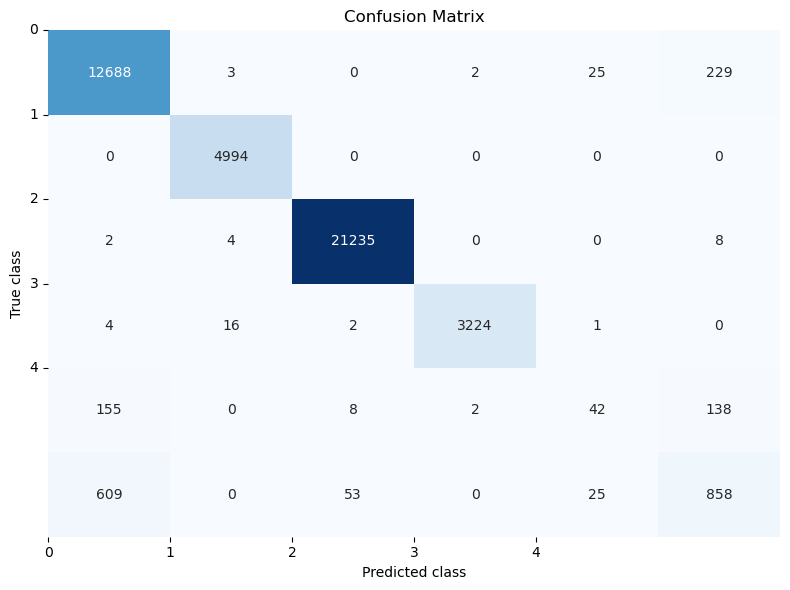

In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the preprocessed test set using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test_preprocessed)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}\n")

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.xticks(ticks=range(5), labels=[0,1,2,3,4])
plt.yticks(ticks=range(5), labels=[0,1,2,3,4], rotation=0)
plt.tight_layout()
plt.show()


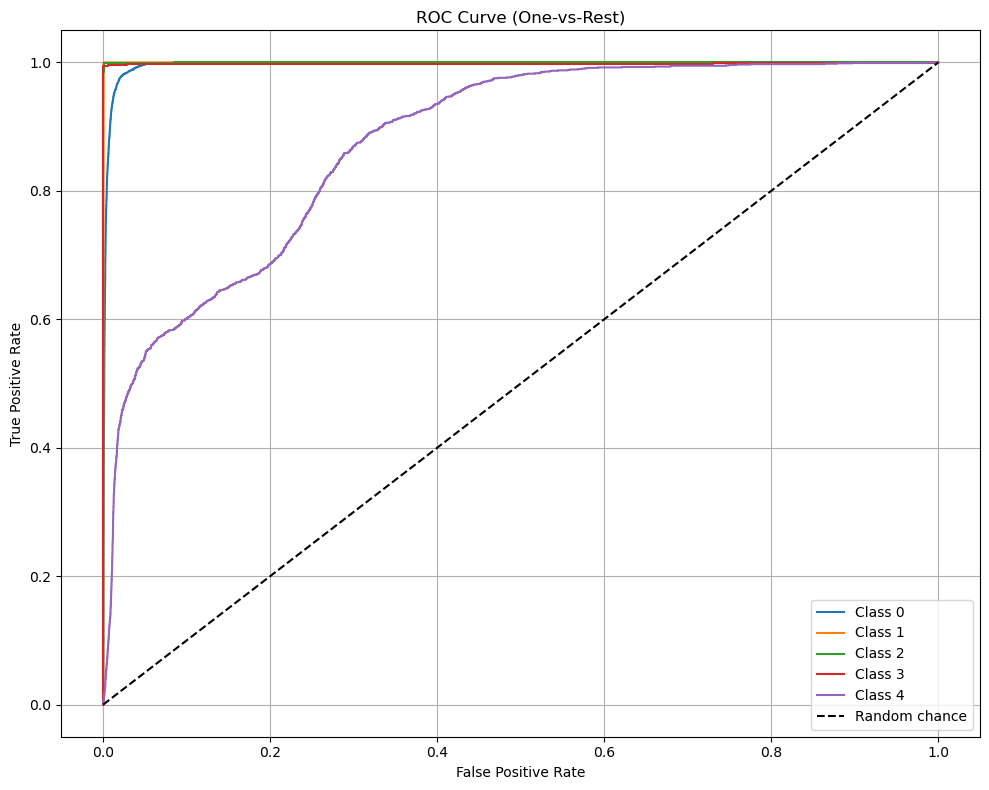

In [50]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Binarize the test labels (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=['movie', 'short', 'tvEpisode', 'tvSeries', 'video'])

# Predict class probabilities on the test set
y_score = grid_search.best_estimator_.predict_proba(X_test_preprocessed)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')

# Add chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Plot formatting
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Balancing

In [51]:
# Logistic Regression con class_weight bilanciato
logreg_balanced = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# Imposta la grid dei parametri (puoi mantenerla o ampliarla)
param_grid_balanced = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
}

grid_search_balanced = GridSearchCV(
    estimator=logreg_balanced,
    param_grid=param_grid_balanced,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit sul subset preprocessed
grid_search_balanced.fit(X_small_preprocessed, y_small)

print("Best parameters with balanced class weights:")
print(grid_search_balanced.best_params_)

print("\nBest weighted F1 score with balanced class weights:")
print(grid_search_balanced.best_score_)

# Valutazione su test set
y_pred_balanced = grid_search_balanced.best_estimator_.predict(X_test_preprocessed)

print(f"Test set accuracy with balanced weights: {accuracy_score(y_test, y_pred_balanced):.4f}")
print("Classification report with balanced weights:")
print(classification_report(y_test, y_pred_balanced, digits=4))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters with balanced class weights:
{'C': 10, 'penalty': 'l2'}

Best weighted F1 score with balanced class weights:
0.9463083213522626
Test set accuracy with balanced weights: 0.9351
Classification report with balanced weights:
              precision    recall  f1-score   support

       movie     0.9849    0.8309    0.9014     12947
       short     0.9970    1.0000    0.9985      4994
   tvEpisode     0.9989    0.9991    0.9990     21249
    tvSeries     0.9988    0.9945    0.9966      3247
   tvSpecial     0.1742    0.6812    0.2774       345
       video     0.3934    0.6518    0.4906      1545

    accuracy                         0.9351     44327
   macro avg     0.7578    0.8596    0.7773     44327
weighted avg     0.9670    0.9351    0.9469     44327



Without ```class_weight='balanced'``` (baseline):

Accuracy is around 60%, but:

- Minority classes (0, 1, 4) are barely recognized, with very low recall and almost zero precision.

- The majority class (3) dominates, showing very high recall (~94%).

- The model is heavily biased towards the most frequent class.

With class_weight='balanced':

- Accuracy drops significantly to around 29%.

- Recall for minority classes improves drastically (e.g., class 0 recall increases from 0 to 51%).

- Precision for minority classes remains low, likely because the model spreads predictions across multiple classes.

- The dominant class (3) loses recall (from 94% down to 23%), but we gain a more balanced recognition across classes.

Considerations:

- Using class_weight='balanced' forces the model not to ignore rare classes but leads to overall lower accuracy.

- Weighted F1 score decreases (from ~0.49 to ~0.35), indicating improved balance but with trade-offs.

- If the goal is to improve minority class recognition this approach is worth exploring further.

- If maximum overall accuracy is preferred, a different strategy may be needed.

In [52]:
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

# Define custom scorers for GridSearch:
# - Macro F1: gives equal weight to all classes, useful for imbalanced data
# - Balanced Accuracy: accounts for imbalance by averaging recall per class
f1_macro_scorer = make_scorer(f1_score, average='macro')
balanced_acc_scorer = make_scorer(balanced_accuracy_score)

# Initialize Logistic Regression model without class_weight for baseline comparison
logreg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',  # Use balanced class weights to handle imbalance
    random_state=42
)

# Parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

# Setup GridSearchCV to optimize macro F1 score instead of accuracy
grid_search_macro_f1 = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring=f1_macro_scorer,  # Optimize for macro F1 to better handle class imbalance
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the preprocessed training subset
grid_search_macro_f1.fit(X_small_preprocessed, y_small)

# Output best hyperparameters and best macro F1 score found during cross-validation
print("Best params (macro F1):", grid_search_macro_f1.best_params_)
print("Best macro F1 score:", grid_search_macro_f1.best_score_)

# Predict on test set using the best estimator from grid search
y_pred_macro_f1 = grid_search_macro_f1.best_estimator_.predict(X_test_preprocessed)

from sklearn.metrics import classification_report, accuracy_score

# Evaluate performance on test set
print(f"Test accuracy (macro F1 optimized): {accuracy_score(y_test, y_pred_macro_f1):.4f}")
print("Classification report (macro F1 optimized):")
print(classification_report(y_test, y_pred_macro_f1, digits=4))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

Best params (macro F1): {'C': 0.01, 'penalty': 'l2'}
Best macro F1 score: nan
Test accuracy (macro F1 optimized): 0.8870
Classification report (macro F1 optimized):
              precision    recall  f1-score   support

       movie     0.9771    0.8233    0.8936     12947
       short     0.8179    0.9856    0.8939      4994
   tvEpisode     0.9922    0.9137    0.9514     21249
    tvSeries     0.9786    0.9837    0.9811      3247
   tvSpecial     0.1203    0.7072    0.2056       345
       video     0.3480    0.5722    0.4328      1545

    accuracy                         0.8870     44327
   macro avg     0.7057    0.8309    0.7264     44327
weighted avg     0.9379    0.8870    0.9063     44327



Experiment summary with ```class_weight='balanced'``` and ```macro F1 optimization```
Adding class_weight='balanced' explicitly forces the model to pay more attention to minority classes by weighting the loss function inversely to class frequency.

Optimizing for macro F1 instead of accuracy focuses training on improving minority class predictions.

Results:

Accuracy drops from ~60% to ~29%, indicating a trade-off when trying to balance class performance.

Recall for minority classes improves significantly, e.g. class 0 recall jumps to ~51%.

Precision for minority classes remains low, suggesting many false positives.

The dominant majority class (3) suffers a recall drop from ~94% to ~23%.

Weighted F1 decreases, macro F1 improves slightly, showing better balance but worse overall performance.

Interpretation: The model is now less biased toward the majority class but less confident overall, resulting in more “spread out” predictions.

In [53]:
# Expanded hyperparameter grid for Logistic Regression with class_weight='balanced'

#We are extending the grid search to explore a wider range of regularization strengths (`C`), multiple penalty types (`l1`, `l2`, `elasticnet`), and solvers (`lbfgs`, `saga`).

#This should help us find better hyperparameters to improve macro F1, especially on minority classes.

#Note: `l1` and `elasticnet` penalties require the `saga` solver, so we separate the grid accordingly.

from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

# Define custom scorers for GridSearch:
# - Macro F1: gives equal weight to all classes, useful for imbalanced data
# - Balanced Accuracy: accounts for imbalance by averaging recall per class
f1_macro_scorer = make_scorer(f1_score, average='macro')
balanced_acc_scorer = make_scorer(balanced_accuracy_score)

# Initialize Logistic Regression model without class_weight for baseline comparison
logreg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',  # Use balanced class weights to handle imbalance
    random_state=42
)

# Parameter grid for hyperparameter tuning
param_grid = [
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000, 2000]},
    {'solver': ['saga'], 'penalty': ['l1', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000, 2000], 'l1_ratio': [0.5]}
]

# Setup GridSearchCV to optimize macro F1 score instead of accuracy
grid_search_macro_f1 = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring=f1_macro_scorer,  # Optimize for macro F1 to better handle class imbalance
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the preprocessed training subset
grid_search_macro_f1.fit(X_small_preprocessed, y_small)

# Output best hyperparameters and best macro F1 score found during cross-validation
print("Best params (macro F1):", grid_search_macro_f1.best_params_)
print("Best macro F1 score:", grid_search_macro_f1.best_score_)

# Predict on test set using the best estimator from grid search
y_pred_macro_f1 = grid_search_macro_f1.best_estimator_.predict(X_test_preprocessed)

from sklearn.metrics import classification_report, accuracy_score

# Evaluate performance on test set
print(f"Test accuracy (macro F1 optimized): {accuracy_score(y_test, y_pred_macro_f1):.4f}")
print("Classification report (macro F1 optimized):")
print(classification_report(y_test, y_pred_macro_f1, digits=4))


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

Best params (macro F1): {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best macro F1 score: nan
Test accuracy (macro F1 optimized): 0.8185
Classification report (macro F1 optimized):
              precision    recall  f1-score   support

       movie     0.9692    0.7959    0.8741     12947
       short     0.6522    0.9584    0.7762      4994
   tvEpisode     0.9788    0.7926    0.8759     21249
    tvSeries     0.6709    0.9824    0.7973      3247
   tvSpecial     0.1166    0.3478    0.1747       345
       video     0.3091    0.6738    0.4238      1545

    accuracy                         0.8185     44327
   macro avg     0.6161    0.7585    0.6537     44327
weighted avg     0.8866    0.8185    0.8372     44327



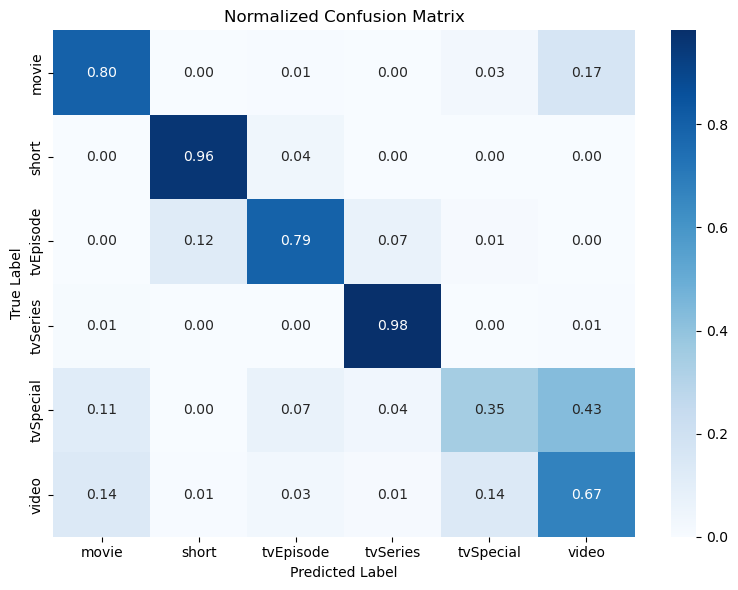

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate normalized confusion matrix
cm = confusion_matrix(y_test, y_pred_macro_f1, normalize='true')

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=grid_search_macro_f1.best_estimator_.classes_, yticklabels=grid_search_macro_f1.best_estimator_.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


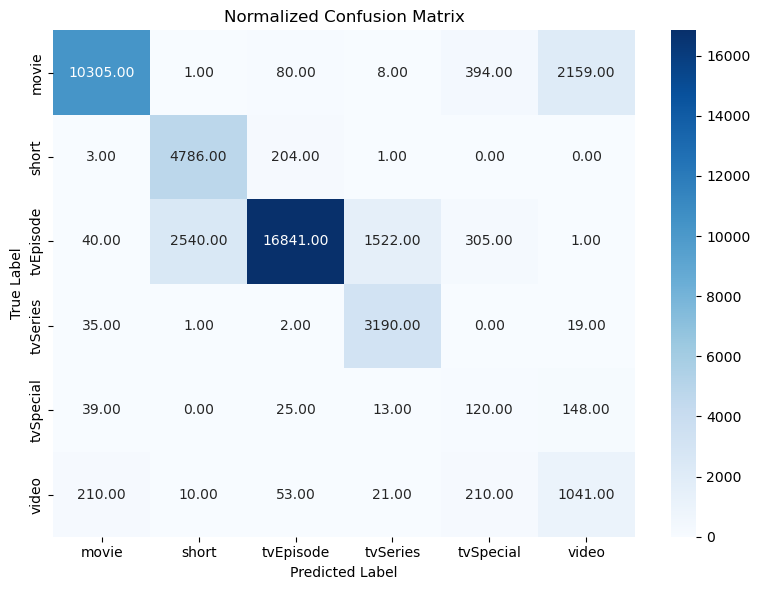

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate normalized confusion matrix
cm = confusion_matrix(y_test, y_pred_macro_f1)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=grid_search_macro_f1.best_estimator_.classes_, yticklabels=grid_search_macro_f1.best_estimator_.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

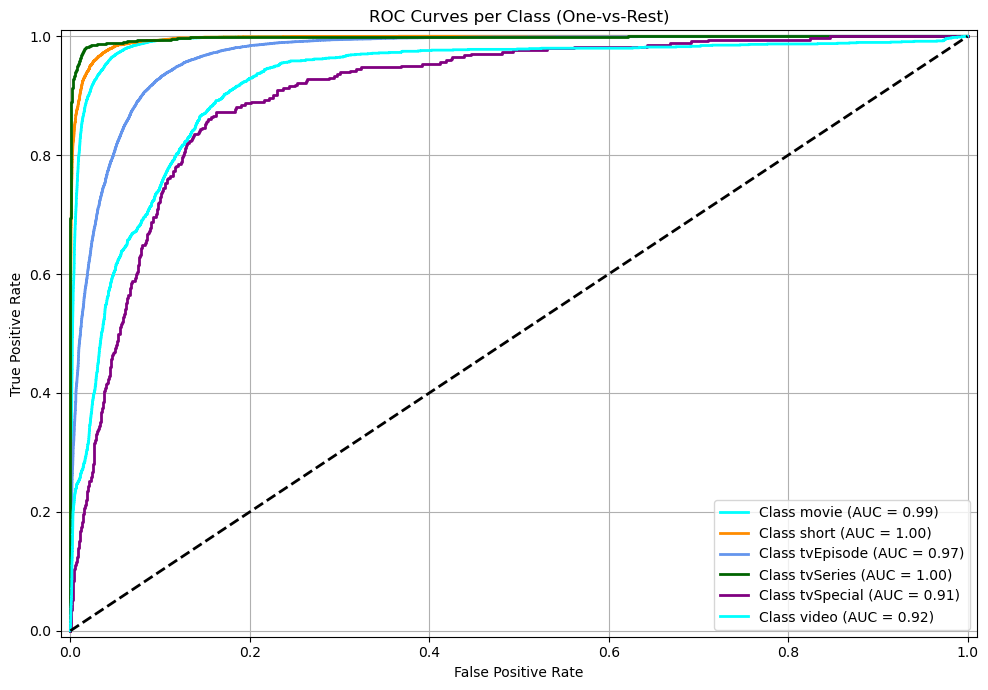

In [59]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Binarize labels for ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities with the best model from grid search
y_score = grid_search_macro_f1.best_estimator_.predict_proba(X_test_preprocessed)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


We use ROC curves to evaluate how well the classifier distinguishes between each class.

- Since this is a multiclass classification problem, we apply the One-vs-Rest (OvR) strategy.
- We compute one ROC curve per class, comparing each class against all others.
- The area under the curve (AUC) is also calculated for each class.

The curves below help visualize:
- How well each class is separated
- Trade-offs between true positive rate and false positive rate
- Whether some classes dominate or get ignored by the model


# One vs Rest

In [34]:
# Logistic Regression using multi_class='ovr' instead of multinomial
# This setup explicitly uses OvR strategy with class_weight='balanced'
# Note: 'saga' solver is required for compatibility with OvR and elasticnet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score, classification_report, accuracy_score

# Define custom scoring functions
f1_macro_scorer = make_scorer(f1_score, average='macro')
balanced_acc_scorer = make_scorer(balanced_accuracy_score)

# Initialize logistic regression with OvR strategy
logreg_ovr = LogisticRegression(
    multi_class='ovr',             # Use One-vs-Rest strategy explicitly
    solver='saga',                 # 'saga' supports l1, l2, elasticnet and ovr
    class_weight='balanced',       # Handle class imbalance
    max_iter=1000,
    random_state=42
)

# Grid of hyperparameters compatible with OvR + saga
param_grid_ovr = {
    'penalty': ['l2', 'l1'],               # Regularization types supported by saga
    'C': [0.001, 0.01, 0.1, 1, 10],        # Regularization strength
    'max_iter': [1000, 2000],
    'class_weight': ['balanced']          # AGGIUNTO ANCHE QUI
}

# from scipy.stats import loguniform  # se vuoi sampling continuo per C

# # Esempio con sampling continuo per 'C'
# param_dist_ovr = {
#     'penalty': ['l1', 'l2'],
#     'C': loguniform(1e-3, 10),
#     'max_iter': [1000, 2000],
#     'class_weight': ['balanced']
# }

# # GridSearchCV to optimize macro F1 score
# grid_search_ovr = GridSearchCV(
#     estimator=logreg_ovr,
#     param_grid=param_grid_ovr,
#     scoring=f1_macro_scorer,
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

random_search_ovr = RandomizedSearchCV(
    estimator=logreg_ovr,
    param_distributions=param_grid_ovr,
    n_iter=10,  # Numero di combinazioni casuali da provare
    scoring=f1_macro_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit grid search
random_search_ovr.fit(X_small_preprocessed, y_small)

# Evaluate
print("Best parameters (OvR):", random_search_ovr.best_params_)
print("Best macro F1 score (OvR):", random_search_ovr.best_score_)

# Predict on test set
y_pred_ovr = random_search_ovr.best_estimator_.predict(X_test_preprocessed)

print(f"Test accuracy (OvR): {accuracy_score(y_test, y_pred_ovr):.4f}")
print("Classification report (OvR):")
print(classification_report(y_test, y_pred_ovr, digits=4))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

Best parameters (OvR): {'penalty': 'l2', 'max_iter': 1000, 'class_weight': 'balanced', 'C': 0.001}
Best macro F1 score (OvR): nan
Test accuracy (OvR): 0.8715
Classification report (OvR):
              precision    recall  f1-score   support

       movie     0.9490    0.8817    0.9141     12947
       short     0.7777    0.7369    0.7567      4994
   tvEpisode     0.9280    0.9314    0.9297     21249
    tvSeries     0.9964    0.9249    0.9593      3247
   tvSpecial     0.1303    0.6435    0.2167       345
       video     0.3432    0.3379    0.3405      1545

    accuracy                         0.8715     44327
   macro avg     0.6874    0.7427    0.6862     44327
weighted avg     0.8956    0.8715    0.8817     44327



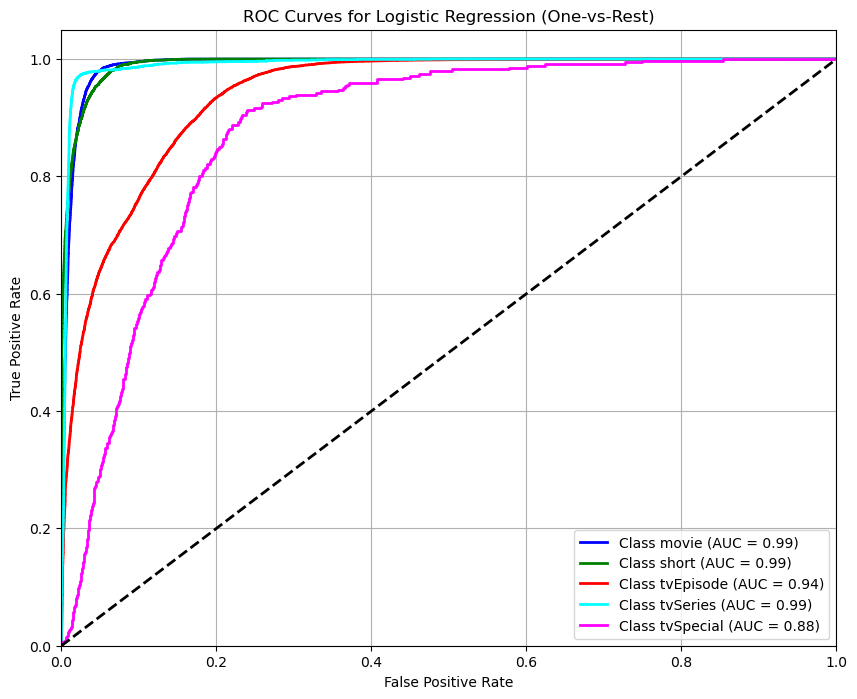

In [35]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarizza le etichette di test per multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Predizioni di probabilità dal modello OvR
y_score = random_search_ovr.best_estimator_.predict_proba(X_test_preprocessed)

# Calcolo ROC e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Traccia ROC curve per tutte le classi
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # linea diagonale (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


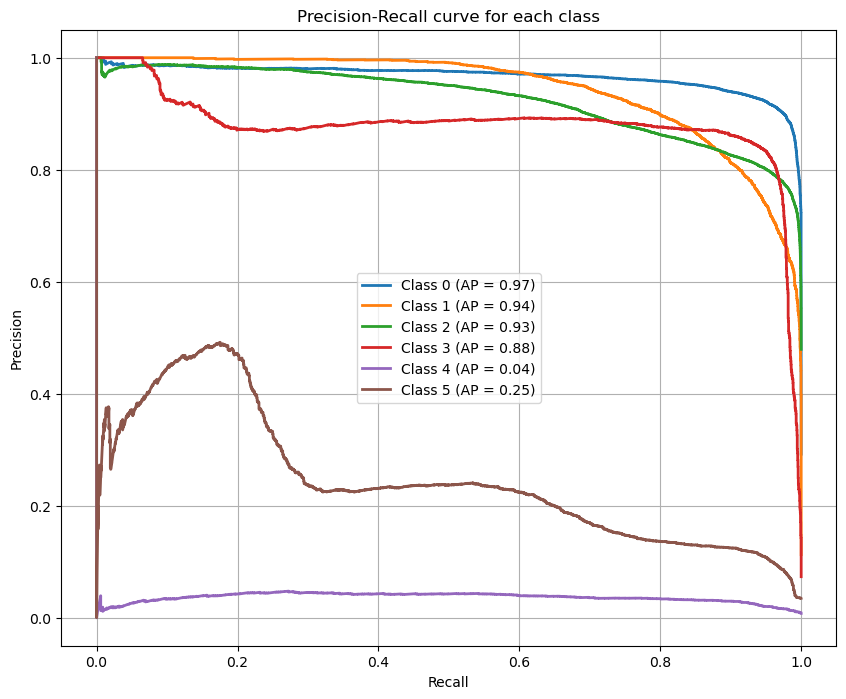

In [36]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Binarize the output labels (multi-class one-vs-rest format)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get predicted probabilities from the best estimator
y_score = random_search_ovr.best_estimator_.predict_proba(X_test_preprocessed)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc='best')
plt.grid(True)
plt.show()



The Average Precision (AP) scores for each class indicate the model’s ability to balance precision and recall across different thresholds:

- Classes 0 and 1 have very low AP scores (0.01 and 0.08), showing that the model struggles to correctly identify these minority classes. This is likely due to their low representation in the dataset and the model favoring majority classes.
- Class 2 has a moderate AP (0.37), indicating somewhat better recognition but still limited performance.
- Class 3, the majority class, achieves the highest AP (0.69), confirming that the model is heavily biased toward predicting this class correctly.
- Class 4 shows an intermediate AP (0.26), better than the rarest classes but still far from ideal.

These results are consistent with the classification report and reflect that without balancing class weights, the model prioritizes accuracy on the dominant classes at the expense of minority class performance.

In [37]:
# Check if the estimator actually has class_weight set
print(random_search_ovr.best_estimator_.get_params()['class_weight'])


balanced


OLD COMMENT

Analysis of Average Precision (AP) with and without `class_weight='balanced'`

We compared the Average Precision (AP) scores of the Logistic Regression model trained with and without `class_weight='balanced'` to handle class imbalance. Surprisingly, the AP values for each class remain almost identical between the two settings. 

This outcome can occur because:

- The `class_weight='balanced'` parameter affects the training process by adjusting the penalty on misclassifications of minority classes. However, if the model's capacity (here, Logistic Regression) or the feature representation is limited, this adjustment might not translate into significant improvements in class separation.
- Logistic Regression is a relatively simple linear model and might not capture complex patterns needed to improve performance on minority classes even with balanced class weights.
- The predicted class probabilities, which directly influence the AP scores, do not change substantially with or without balancing, resulting in nearly unchanged AP values.

In summary, while `class_weight='balanced'` is conceptually helpful for imbalanced data, its practical impact depends on model complexity and data characteristics. For stronger improvements, more expressive models or data-level balancing techniques might be necessary.


# RFE

In [39]:
from sklearn.feature_selection import RFE

best_model = random_search_ovr.best_estimator_

X_small_preprocessed = pd.DataFrame(X_small_preprocessed, columns=X_small.columns)

# Applica RFE usando il modello già ottimizzato
rfe = RFE(estimator=best_model, n_features_to_select=15)
rfe.fit(X_small_preprocessed, y_small)

# Seleziona le feature
selected_features = X_small_preprocessed.columns[rfe.support_]

ranking = pd.DataFrame({
    'Feature': X_small_preprocessed.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

print("📌 Feature selezionate da RFE:")
print(selected_features.tolist())

print("\n📊 Ranking completo delle feature:")
print(ranking)

# Applica la selezione ai dati
X_train_selected = X_small_preprocessed[selected_features]
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
X_test_selected = X_test_preprocessed[selected_features]
X_test_selected = X_test_preprocessed[selected_features]

# (Ri)allena il modello migliore solo sulle feature selezionate
best_model.fit(X_train_selected, y_small)
y_pred_rfe = best_model.predict(X_test_selected)

# Valutazione finale
from sklearn.metrics import classification_report
print("Report finale dopo RFE con best model:")
print(classification_report(y_test, y_pred_rfe, digits=4))

📌 Feature selezionate da RFE:
['startYear', 'runtimeMinutes', 'companiesNumber', 'averageRating', 'totalNominations', 'deltaCredits', 'isAdult', 'canHaveEpisodes', 'regions_EU', 'regions_NA', 'regions_AS', 'regions_UNK', 'countryOfOrigin_NA', 'countryOfOrigin_AS', 'countryOfOrigin_EU']

📊 Ranking completo delle feature:
                Feature  Selected  Ranking
0             startYear      True        1
23   countryOfOrigin_EU      True        1
22   countryOfOrigin_AS      True        1
20   countryOfOrigin_NA      True        1
19          regions_UNK      True        1
15           regions_AS      True        1
14           regions_NA      True        1
12      canHaveEpisodes      True        1
11              isAdult      True        1
13           regions_EU      True        1
8      totalNominations      True        1
6         averageRating      True        1
5       companiesNumber      True        1
1        runtimeMinutes      True        1
9          deltaCredits      True

In [40]:
print(type(best_model))
print(best_model)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000,
                   multi_class='ovr', random_state=42, solver='saga')
